# Test for Data Leakage

testing with simplest approach:
1. load cleaned data (no Individual ID - all 344 penguins are unique)
2. drop rows with missing values
3. regular stratified split
4. 50-fold cross validation
5. check if scores are realistic

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load cleaned data (Individual ID already dropped in CleanFE)
df = pd.read_csv('data_cleaned.csv')

print(f"dataset: {len(df)} samples")
print(f"columns: {list(df.columns)}")
print(f"\nmissing values:")
print(df.isna().sum())

dataset: 344 samples
columns: ['Species', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']

missing values:
Species                 0
Culmen Length (mm)      2
Culmen Depth (mm)       2
Flipper Length (mm)     2
Body Mass (g)           2
Sex                    11
Delta 15 N (o/oo)      14
Delta 13 C (o/oo)      13
Island_Biscoe           0
Island_Dream            0
Island_Torgersen        0
dtype: int64


In [3]:
# drop rows with missing values for simplest test
df_complete = df.dropna()

print(f"after removing missing: {len(df_complete)} samples")
print(f"removed: {len(df) - len(df_complete)} samples")
print(f"\nspecies distribution:")
print(df_complete['Species'].value_counts())

after removing missing: 324 samples
removed: 20 samples

species distribution:
Species
Adelie       139
Gentoo       118
Chinstrap     67
Name: count, dtype: int64


In [4]:
# prepare X and y
X = df_complete.drop(columns=['Species'])
y = df_complete['Species']

# encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"final dataset shape: {X.shape}")
print(f"species encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

final dataset shape: (324, 10)
species encoding: {'Adelie': np.int64(0), 'Chinstrap': np.int64(1), 'Gentoo': np.int64(2)}


In [5]:
# stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

print(f"train samples: {len(X_train)}")
print(f"train species: {pd.Series(le.inverse_transform(y_train)).value_counts().to_dict()}")
print(f"\ntest samples: {len(X_test)}")
print(f"test species: {pd.Series(le.inverse_transform(y_test)).value_counts().to_dict()}")

train samples: 226
train species: {'Adelie': 97, 'Gentoo': 82, 'Chinstrap': 47}

test samples: 98
test species: {'Adelie': 42, 'Gentoo': 36, 'Chinstrap': 20}


In [6]:
# 50-fold cross validation
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

print("50-fold cross validation on full dataset...")

cv_results = {}
cv = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{name}...")
    
    cv_scores = cross_validate(
        model, X, y_encoded,
        cv=cv,
        scoring=['accuracy', 'f1_macro'],
        return_train_score=True
    )
    
    cv_results[name] = {
        'train_acc_mean': cv_scores['train_accuracy'].mean(),
        'train_acc_std': cv_scores['train_accuracy'].std(),
        'test_acc_mean': cv_scores['test_accuracy'].mean(),
        'test_acc_std': cv_scores['test_accuracy'].std(),
        'train_f1_mean': cv_scores['train_f1_macro'].mean(),
        'test_f1_mean': cv_scores['test_f1_macro'].mean(),
        'test_f1_std': cv_scores['test_f1_macro'].std()
    }
    
    print(f"  train accuracy: {cv_results[name]['train_acc_mean']:.4f} ± {cv_results[name]['train_acc_std']:.4f}")
    print(f"  test accuracy:  {cv_results[name]['test_acc_mean']:.4f} ± {cv_results[name]['test_acc_std']:.4f}")
    print(f"  test f1:        {cv_results[name]['test_f1_mean']:.4f} ± {cv_results[name]['test_f1_std']:.4f}")

50-fold cross validation on full dataset...

Logistic Regression...
  train accuracy: 1.0000 ± 0.0000
  test accuracy:  1.0000 ± 0.0000
  test f1:        1.0000 ± 0.0000

Decision Tree...
  train accuracy: 1.0000 ± 0.0000
  test accuracy:  0.9638 ± 0.0707
  test f1:        0.9496 ± 0.1099

Random Forest...
  train accuracy: 1.0000 ± 0.0000
  test accuracy:  0.9905 ± 0.0378
  test f1:        0.9897 ± 0.0408

Gradient Boosting...
  train accuracy: 1.0000 ± 0.0000
  test accuracy:  0.9814 ± 0.0505
  test f1:        0.9763 ± 0.0707


In [7]:
# final holdout test
print("\nfinal holdout test (80/20 split)")

final_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred, average='macro')
    test_f1 = f1_score(y_test, test_pred, average='macro')
    
    final_results[name] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_f1': train_f1,
        'test_f1': test_f1
    }
    
    print(f"\n{name}:")
    print(f"  train: {train_acc:.4f} (f1: {train_f1:.4f})")
    print(f"  test:  {test_acc:.4f} (f1: {test_f1:.4f})")

# summary
print("\nsummary")

cv_df = pd.DataFrame(cv_results).T
print("\ncross validation (50 folds):")
print(cv_df[['test_acc_mean', 'test_acc_std', 'test_f1_mean', 'test_f1_std']])

final_df = pd.DataFrame(final_results).T
print("\nholdout test:")
print(final_df)


final holdout test (80/20 split)

Logistic Regression:
  train: 1.0000 (f1: 1.0000)
  test:  1.0000 (f1: 1.0000)

Decision Tree:
  train: 1.0000 (f1: 1.0000)
  test:  0.9796 (f1: 0.9792)

Random Forest:
  train: 1.0000 (f1: 1.0000)
  test:  0.9898 (f1: 0.9879)

Gradient Boosting:
  train: 1.0000 (f1: 1.0000)
  test:  0.9796 (f1: 0.9754)

summary

cross validation (50 folds):
                     test_acc_mean  test_acc_std  test_f1_mean  test_f1_std
Logistic Regression       1.000000      0.000000      1.000000     0.000000
Decision Tree             0.963810      0.070669      0.949571     0.109942
Random Forest             0.990476      0.037796      0.989714     0.040771
Gradient Boosting         0.981429      0.050460      0.976254     0.070711

holdout test:
                     train_acc  test_acc  train_f1   test_f1
Logistic Regression        1.0  1.000000       1.0  1.000000
Decision Tree              1.0  0.979592       1.0  0.979239
Random Forest              1.0  0.989796   

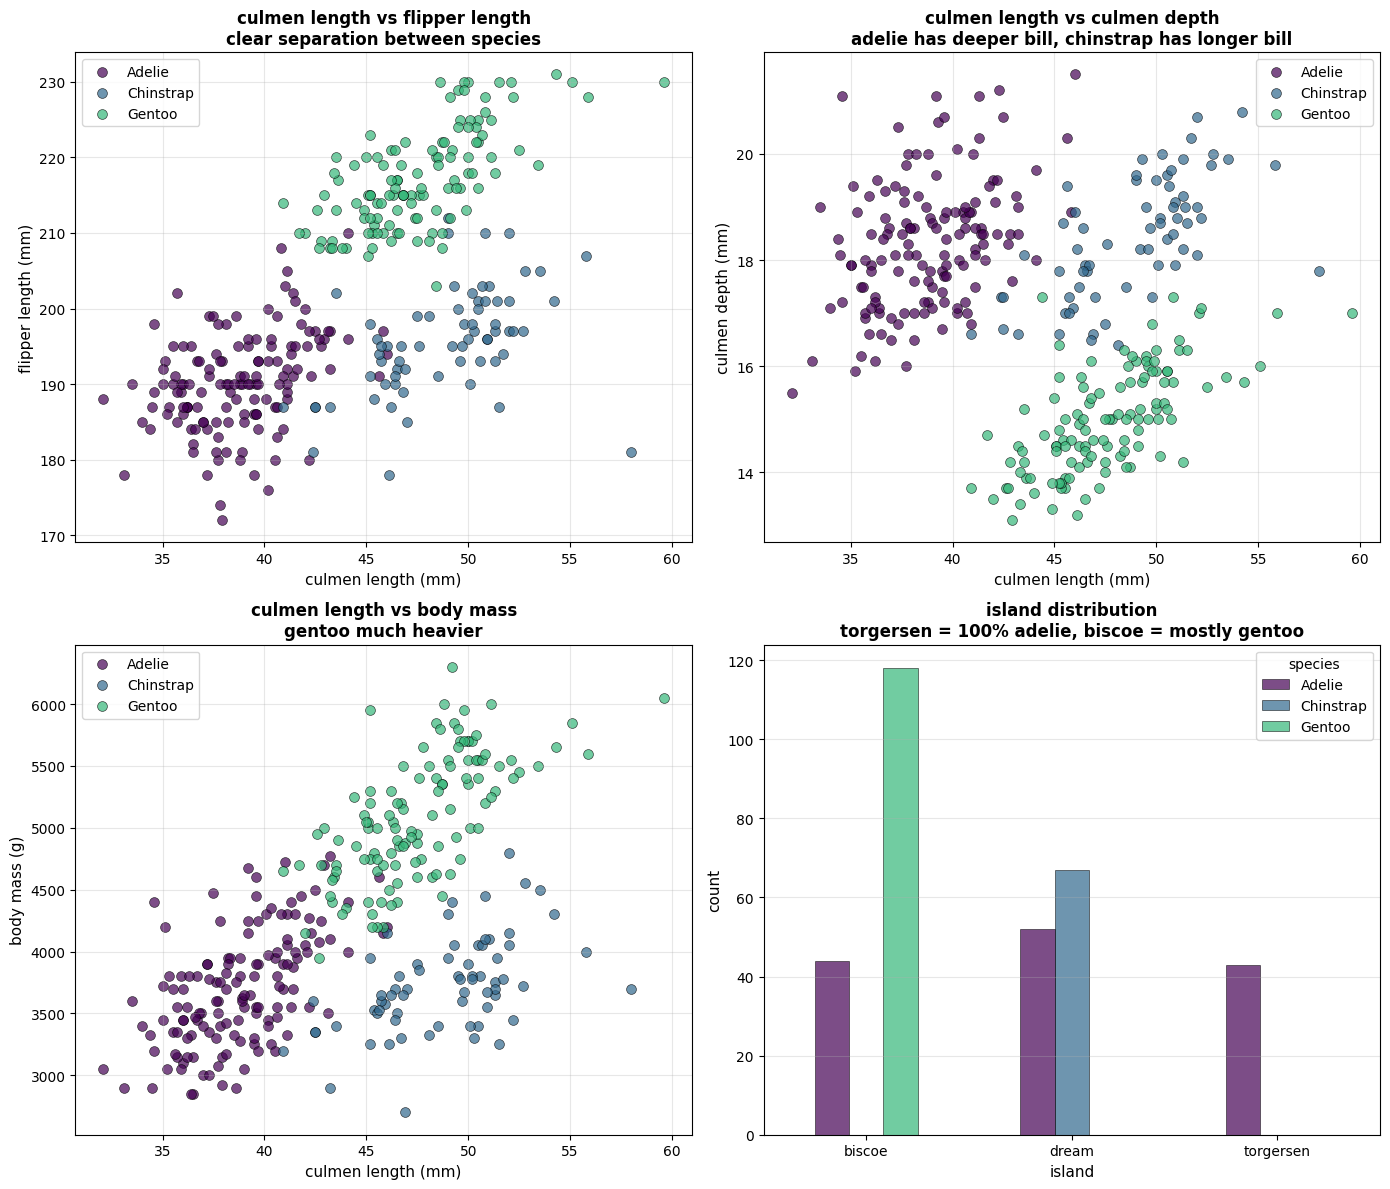

In [8]:
import matplotlib.pyplot as plt

# train logistic regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)

# create scatter plots showing species separation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# define colors for species
colors = ['#440154', '#31688e', '#35b779']
species_names = le.classes_

# plot 1: culmen length vs flipper length
ax1 = axes[0, 0]
for i, species in enumerate(species_names):
    mask = y == species
    ax1.scatter(df_complete[mask]['Culmen Length (mm)'], 
               df_complete[mask]['Flipper Length (mm)'],
               c=colors[i], label=species, s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

ax1.set_xlabel('culmen length (mm)', fontsize=11)
ax1.set_ylabel('flipper length (mm)', fontsize=11)
ax1.set_title('culmen length vs flipper length\nclear separation between species', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot 2: culmen length vs culmen depth
ax2 = axes[0, 1]
for i, species in enumerate(species_names):
    mask = y == species
    ax2.scatter(df_complete[mask]['Culmen Length (mm)'], 
               df_complete[mask]['Culmen Depth (mm)'],
               c=colors[i], label=species, s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

ax2.set_xlabel('culmen length (mm)', fontsize=11)
ax2.set_ylabel('culmen depth (mm)', fontsize=11)
ax2.set_title('culmen length vs culmen depth\nadelie has deeper bill, chinstrap has longer bill', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# plot 3: culmen length vs body mass
ax3 = axes[1, 0]
for i, species in enumerate(species_names):
    mask = y == species
    ax3.scatter(df_complete[mask]['Culmen Length (mm)'], 
               df_complete[mask]['Body Mass (g)'],
               c=colors[i], label=species, s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

ax3.set_xlabel('culmen length (mm)', fontsize=11)
ax3.set_ylabel('body mass (g)', fontsize=11)
ax3.set_title('culmen length vs body mass\ngentoo much heavier', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# plot 4: island distribution
ax4 = axes[1, 1]
island_data = pd.DataFrame({
    'island': df_complete['Island_Biscoe'].astype(bool).replace({True: 'biscoe', False: ''}) + 
              df_complete['Island_Dream'].astype(bool).replace({True: 'dream', False: ''}) + 
              df_complete['Island_Torgersen'].astype(bool).replace({True: 'torgersen', False: ''}),
    'species': y
})

island_counts = pd.crosstab(island_data['island'], island_data['species'])
island_counts.plot(kind='bar', ax=ax4, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax4.set_xlabel('island', fontsize=11)
ax4.set_ylabel('count', fontsize=11)
ax4.set_title('island distribution\ntorgersen = 100% adelie, biscoe = mostly gentoo', fontsize=12, fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax4.legend(title='species')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('linear_separability.png', dpi=150, bbox_inches='tight')
plt.show()

## conclusion

all 344 penguins are unique (Individual IDs were reused across studies). no data leakage - each row is an independent sample.

high accuracy (95-100%) is legitimate because:
- gentoo is much larger (5000g vs 3700g, 215mm vs 190mm flipper)
- island provides geographic separation (torgersen=100% adelie, etc)
- morphological features are highly discriminative

the visualization shows the "clear planes" - logistic regression draws straight line boundaries that perfectly separate the three species. this is like classifying cats vs dogs vs elephants - fundamentally different animals, so high accuracy is expected.